In [200]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import Counter
from imblearn.over_sampling import SMOTE, RandomOverSampler
import nltk.data

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [201]:
# read the dataset
reviews_data = pd.read_json(r"C:\Users\user\Documents\UoM\Thesis\data\Clothing_Shoes_and_Jewelry_5.json", lines=True)

# Keep only the review text and the grade
reviews_data = reviews_data[['overall', 'reviewText']]


# Drop the products whose values are null
reviews_data = reviews_data[reviews_data['reviewText'].notna()]

In [202]:
ratings = []
for index,entry in enumerate(reviews_data['overall']):
    if entry == 1.0 or entry == 2.0:
        ratings.append(-1)
    elif entry == 3.0:
        ratings.append(0)
    elif entry == 4.0 or entry == 5.0:
        ratings.append(1)

In [203]:
reviews_data = reviews_data[reviews_data.index < 10000]
ratings = ratings[:10000]

In [204]:
""""
Split each review into sentences
and preprocess each sentence
"""
stopwords = stopwords.words('english')
stopwords.remove('not')
stopwords.extend(['wear', 'shoe', 'size', 'fit', 'look', 'one', 'good'])

sentenceEnders = re.compile('[.!?]')

preprocessed_data = []
index = 0
for review in reviews_data['reviewText']:
    review_sentences = sentenceEnders.split(review)
    for sentence in review_sentences:
        sentence = re.sub(r'not a *', 'not',sentence)
        sentence = re.sub(r'not *', 'not',sentence) 
        sentence = re.sub(r"\w+n't ", ' not',sentence) 
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)
        sentence = sentence.lower()
        sentence = word_tokenize(sentence)
        sentence = [word for word in sentence if not word in stopwords]
        sentence = ' '.join(sentence)
        if(sentence != ''):
            review = {}
            review["index"] = index
            review["sentence"] = sentence
            review["rating"] = ratings[index]
            preprocessed_data.append(review)
    index += 1

100% of the total reviews have been preprocessed


In [208]:
print("Before preprocessing: ", reviews_data['reviewText'][70])
print("------------------------------------------------")
print("After preprocessing: ", [d for d in preprocessed_data if d['index'] == 70])

Before preprocessing:  Have they lost their minds??!! Over 100$ for a costume!! Amazon, you are an idiot. This is an inexpensive costume. It better include a meeting with Tom Hanks for that price.
------------------------------------------------
After preprocessing:  [{'index': 70, 'sentence': 'lost minds', 'rating': -1}, {'index': 70, 'sentence': 'costume', 'rating': -1}, {'index': 70, 'sentence': 'amazon idiot', 'rating': -1}, {'index': 70, 'sentence': 'inexpensive costume', 'rating': -1}, {'index': 70, 'sentence': 'better include meeting tom hanks price', 'rating': -1}]
notgood


In [206]:
# Split Dataset into training and test
indexes = [i for i in range(len(reviews_data))]

Train_X_index, Test_X_index, Train_Y_review, Test_Y_review = model_selection.train_test_split(indexes,
                                                                                               ratings,
                                                                                               test_size=0.4, 
                                                                                               random_state=42)
df = pd.DataFrame(preprocessed_data)

train = df[df['index'].isin(Train_X_index)]
Train_Y = train['rating'].tolist()
Train_X = train['sentence'].tolist()
Train_index = train['index'].tolist()


test = df[df['index'].isin(Test_X_index)]
Test_Y = test['rating'].tolist()
Test_X = test['sentence'].tolist()
Test_index = test['index'].tolist()

all_sentences = Train_X + Test_X

In [187]:
len(df)

48062

In [188]:
# Word Vectorization   
TfIdf_vect = TfidfVectorizer(max_features=10000)
TfIdf_vect.fit(all_sentences)
Train_X_TfIdf = TfIdf_vect.transform(Train_X)
Test_X_TfIdf = TfIdf_vect.transform(Test_X)

In [189]:
# Oversampling 
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(Train_X_TfIdf, Train_Y)

In [190]:
def find_Max_Element(scores):
    c = Counter(scores)
    negatives = c[-1]
    neutral = c[0]
    positives = c[1]
    
    if(scores[0] == -1):
        negatives += 1
    elif(scores[0] == 0):
        neutral += 1
    elif(scores[0] == 1):
        positives += 1
    
    if(scores[-1] == -1):
        negatives += 1
    elif(scores[-1] == 0):
        neutral += 1
    elif(scores[-1] == 1):
        positives += 1

    if(neutral == positives and neutral > negatives and positives > negatives):
        max_element = 1
    elif (neutral == negatives and neutral > positives and negatives > positives):
        max_element = -1
    elif (neutral == negatives and negatives == positives):
        max_element = 0
    elif (positives == negatives and positives > neutral and negatives > neutral) :
        max_element = 0
    else:
        max_element = max(set(scores), key = scores.count)
        
    return max_element


-3
Accuracy:  76.78258694020515
--------------------------
              precision    recall  f1-score   support

    Negative       0.35      0.53      0.42       342
     Neutral       0.14      0.13      0.14       359
    Positive       0.90      0.86      0.88      3296

    accuracy                           0.77      3997
   macro avg       0.46      0.51      0.48      3997
weighted avg       0.78      0.77      0.77      3997



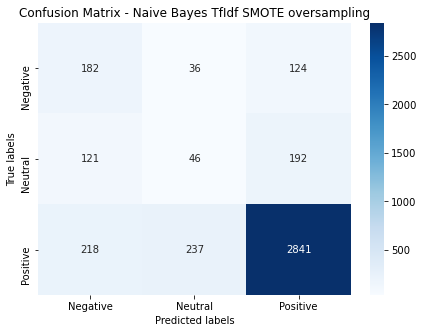

In [191]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_over, y_over)

# predict the labels on validation dataset
predictions_NB_sentences = Naive.predict(Test_X_TfIdf)

# Get grades by review
predicted_scores_frame = pd.DataFrame(np.column_stack([Test_index, predictions_NB_sentences, Test_Y]), 
                               columns=['review Index', 'prediction', 'actual'])

print(len(predicted_scores_frame['review Index'].unique()) - len(Test_Y_review))

# for each review get all scores by review
scores_by_review_frame = predicted_scores_frame.groupby('review Index')['prediction'].apply(list)
majority_scores =  scores_by_review_frame.apply(find_Max_Element)
predicted_scores = list(majority_scores)

# for each review get its actual score
actual_scores_frame = predicted_scores_frame.groupby('review Index')['actual'].first()
actual_scores = list(actual_scores_frame)

# get all indexes
review_indexes = predicted_scores_frame['review Index'].unique()

# Calculate Accuracy
accuracy = accuracy_score(predicted_scores, actual_scores)*100
print("Accuracy: ", accuracy)
print("--------------------------")

# Confusion Matrix
cm = confusion_matrix(actual_scores, predicted_scores)
plt.figure(figsize = (7,5))
ax = plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',ax=ax)
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - Naive Bayes TfIdf SMOTE oversampling'); 
ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive']); 
ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive']);

# Classification Report
my_tags = ['Negative','Neutral','Positive']
print(classification_report(actual_scores, predicted_scores, target_names=my_tags))
report = classification_report(actual_scores, predicted_scores, target_names=my_tags, output_dict=True);
clsf_report = pd.DataFrame(report).transpose()
clsf_report.to_csv('reports/NaiveBayes_TfIdf_Oversampling.csv', index= True)